In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [3]:
tf.random.set_seed(12345)

In [4]:
# pip install -U numpy==1.18.5

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
f = h5py.File("autobuses_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [7]:
scaled_X

masked_array(
  data=[[0.2837714110688417],
        [0.2567122741025271],
        [0.23912386595614266],
        [0.19535095749070136],
        [0.1889398942848181],
        [0.2045220116998225],
        [0.19208976198612912],
        [0.1914388614550879],
        [0.2253793690102232],
        [0.21734893222221677],
        [0.21975186675055733],
        [0.2288335339662706],
        [0.26750810341212367],
        [0.23676018743897828],
        [0.24794605483313759],
        [0.2767889461618248],
        [0.31452145829157746],
        [0.3814400518734439],
        [0.4489321812461507],
        [0.5283936623158055],
        [0.5985012747718995],
        [0.5918256729407801],
        [0.6099935700204288],
        [0.6142172308721929],
        [0.594727941331741],
        [0.5847285883143345],
        [0.5617817040338946],
        [0.5580177368377085],
        [0.51068989060019],
        [0.5155332730898345],
        [0.48828537397250066],
        [0.44822496345718615],
        [0.3998539

In [8]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

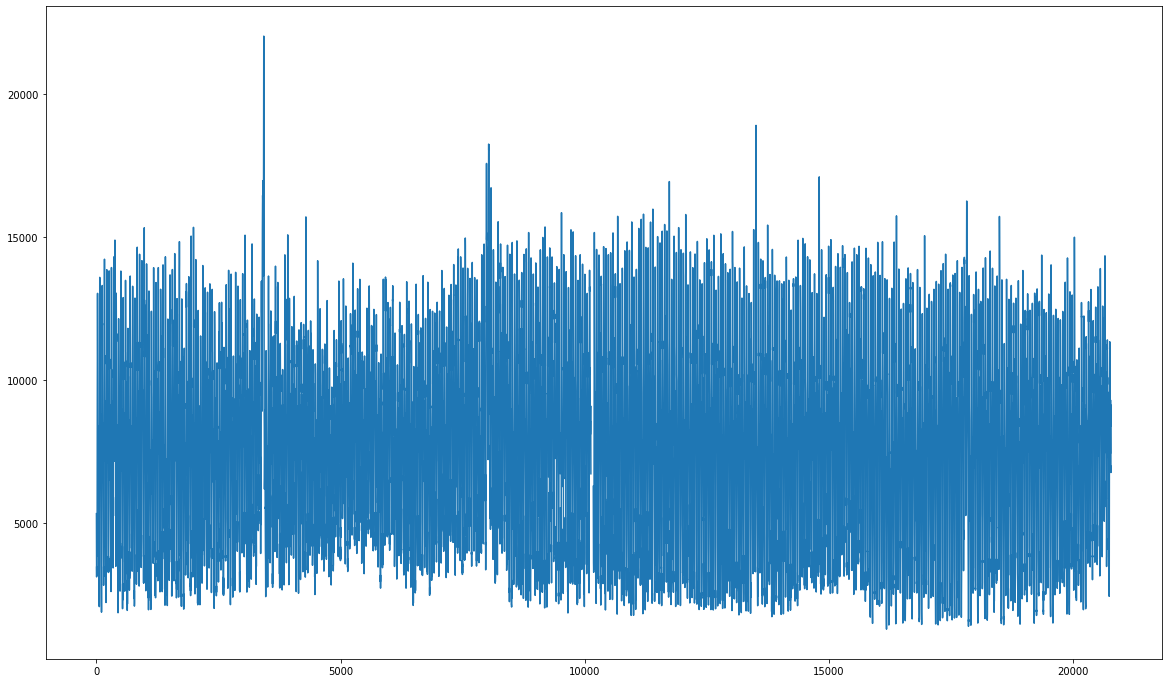

In [9]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.savefig('data.jpg')
plt.show()

In [10]:
int(0.25*len(scaled_X))

5196

In [11]:
def partitionSet(test_fraction, data, partition):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partition/100)*lenX):int((partition/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partition/100)*lenX)-1],data[int((partition/100)*lenX)+test_size:]))
    train_df[int((partition/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

[train_df,test_df] = partitionSet(0.25,scaled_X, 73)

In [12]:
timesteps = 24

In [13]:
X_train = ma.array([train_df[t:t+timesteps] for t in range(0, len(train_df)-timesteps)])
y_train = train_df[timesteps:, :]
X_test = ma.array([test_df[t:t+timesteps] for t in range(0, len(test_df)-timesteps)]) 
y_test = test_df[timesteps:, :]

In [14]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    #model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    #model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam')
    X_ = ma.filled(X_train,0)
    Y_ = ma.filled(y_train,0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False)
    return model, MODEL

In [15]:
X_train.shape[1]

24

In [16]:
model, MODEL = LSTM_function(64, X_train.shape[1], 1, 0.2, 200, 128, 0.2)

Epoch 1/200
98/98 [==============================] - 9s 30ms/step - loss: 0.0277 - val_loss: 0.0224
Epoch 2/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0192 - val_loss: 0.0182
Epoch 3/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0153 - val_loss: 0.0133
Epoch 4/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0139 - val_loss: 0.0120
Epoch 5/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0118 - val_loss: 0.0106
Epoch 6/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0100 - val_loss: 0.0089
Epoch 7/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 8/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 9/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 10/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0041 - val_loss: 0.0039

98/98 [==============================] - 1s 12ms/step - loss: 9.4478e-04 - val_loss: 8.6939e-04
Epoch 82/200
98/98 [==============================] - 1s 12ms/step - loss: 9.4011e-04 - val_loss: 8.7094e-04
Epoch 83/200
98/98 [==============================] - 1s 12ms/step - loss: 9.3591e-04 - val_loss: 8.7359e-04
Epoch 84/200
98/98 [==============================] - 1s 12ms/step - loss: 9.3178e-04 - val_loss: 8.7581e-04
Epoch 85/200
98/98 [==============================] - 1s 12ms/step - loss: 9.2800e-04 - val_loss: 8.7868e-04
Epoch 86/200
98/98 [==============================] - 1s 12ms/step - loss: 9.2425e-04 - val_loss: 8.8095e-04
Epoch 87/200
98/98 [==============================] - 1s 13ms/step - loss: 9.2075e-04 - val_loss: 8.8354e-04
Epoch 88/200
98/98 [==============================] - 1s 12ms/step - loss: 9.1708e-04 - val_loss: 8.8470e-04
Epoch 89/200
98/98 [==============================] - 1s 12ms/step - loss: 9.1383e-04 - val_loss: 8.8649e-04
Epoch 90/200
98/98 [============

Epoch 156/200
98/98 [==============================] - 1s 13ms/step - loss: 7.9454e-04 - val_loss: 8.7622e-04
Epoch 157/200
98/98 [==============================] - 1s 12ms/step - loss: 8.0870e-04 - val_loss: 8.8200e-04
Epoch 158/200
98/98 [==============================] - 1s 12ms/step - loss: 8.0314e-04 - val_loss: 8.5943e-04
Epoch 159/200
98/98 [==============================] - 1s 12ms/step - loss: 8.0625e-04 - val_loss: 8.7485e-04
Epoch 160/200
98/98 [==============================] - 1s 13ms/step - loss: 7.9256e-04 - val_loss: 8.6837e-04
Epoch 161/200
98/98 [==============================] - 1s 13ms/step - loss: 7.9248e-04 - val_loss: 8.7011e-04
Epoch 162/200
98/98 [==============================] - 1s 13ms/step - loss: 7.8786e-04 - val_loss: 8.6475e-04
Epoch 163/200
98/98 [==============================] - 1s 13ms/step - loss: 7.8778e-04 - val_loss: 8.7111e-04
Epoch 164/200
98/98 [==============================] - 1s 13ms/step - loss: 7.8467e-04 - val_loss: 8.6638e-04
Epoch 165/

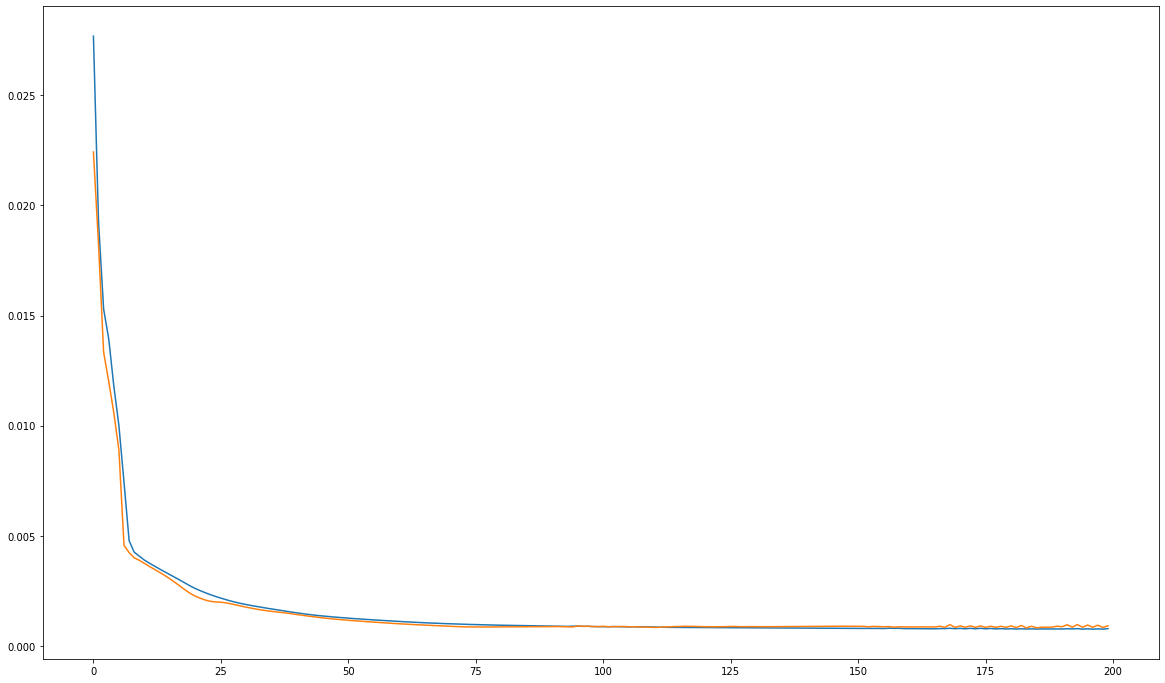

In [17]:
plt.plot(MODEL.history['loss'])
plt.plot(MODEL.history['val_loss'])
plt.show()

In [18]:
prediction_test = model.predict(X_test)

In [19]:
prediction_train = model.predict(X_train)

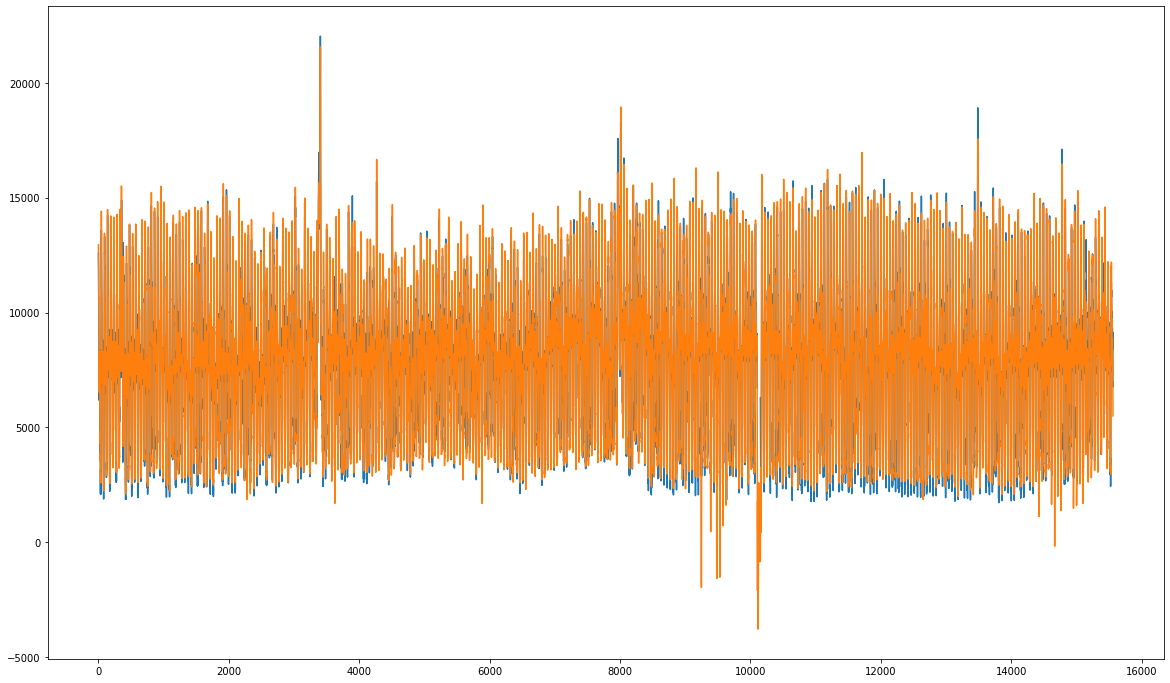

In [20]:
plt.plot(inverse_scaler(y_train[:,0],minX,maxX))
plt.plot(inverse_scaler(prediction_train[:,0],minX,maxX))
plt.show()

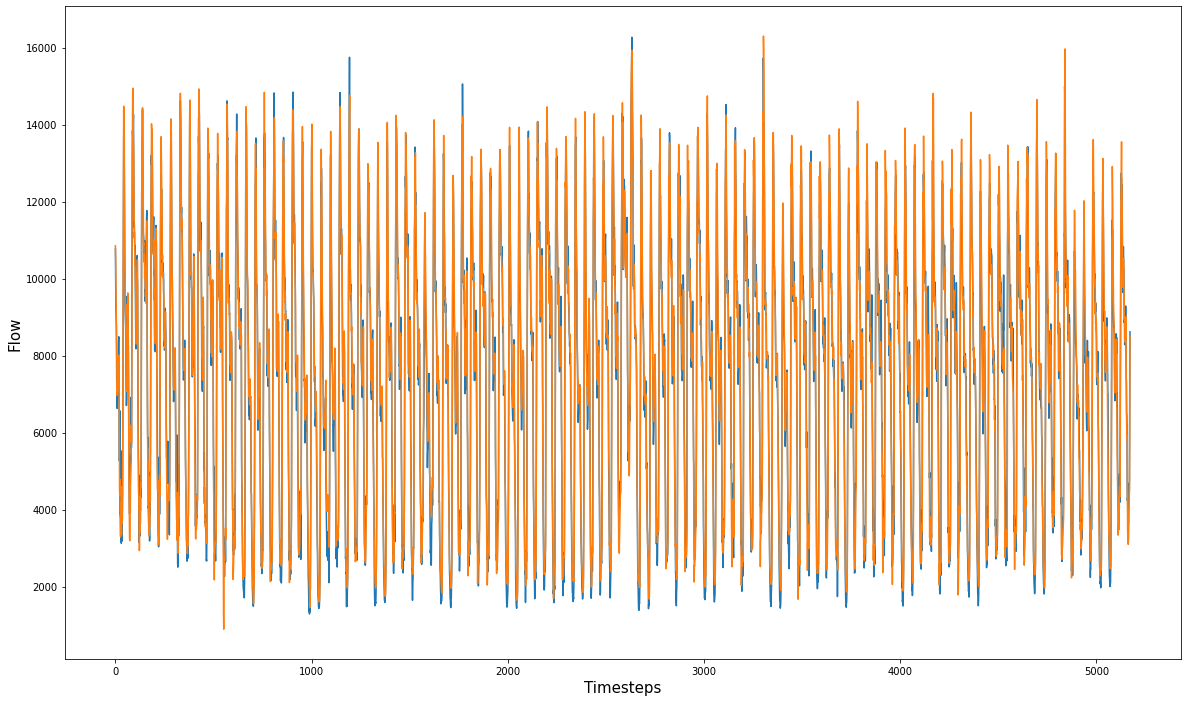

In [21]:
plt.plot(inverse_scaler(y_test[:,0],minX,maxX))
plt.plot(inverse_scaler(prediction_test[:,0],minX,maxX))
plt.xlabel('Timesteps', fontsize = 15)
plt.ylabel('Flow', fontsize = 15)
plt.savefig('PredictionOnLastPartition.jpg')
plt.show()

In [22]:
inputs = scaled_X[len(scaled_X) - len(test_df) - timesteps:]

In [23]:
inputs

masked_array(
  data=[[0.19420456374335335],
        [0.1725568522719666],
        [0.19384080011768964],
        [0.21450507951475334],
        [0.22158126797096725],
        [0.2600596622298475],
        [0.33040802762924876],
        [0.409153383341858],
        [0.5142883859118363],
        [0.5828843508974388],
        [0.6358248582345334],
        [0.672119518960275],
        [0.6597150863384668],
        [0.6413186089448568],
        [0.5838370192564168],
        [0.5501385370513401],
        [0.4933796580832113],
        [0.4837001401352843],
        [0.4887703310547995],
        [0.47441033495924817],
        [0.4743400874028269],
        [0.4360688493919242],
        [0.415870630298465],
        [0.37843022608540067],
        [0.3746178113564676],
        [0.3800789900632573],
        [0.4029576376595472],
        [0.38504557927968247],
        [0.4247378658606253],
        [0.47350641757316336],
        [0.4825651526419903],
        [0.5114118220112184],
        [0.505557354

In [24]:
inputs = inputs.reshape(-1,1)

In [25]:
X_test = []

In [26]:
for i in range(24, 360):
    X_test.append(inputs[i-timesteps:i,0])

In [27]:
X_test = np.array(X_test)

In [28]:
X_test.shape

(336, 24)

In [29]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [30]:
predicted_demand = model.predict(X_test)

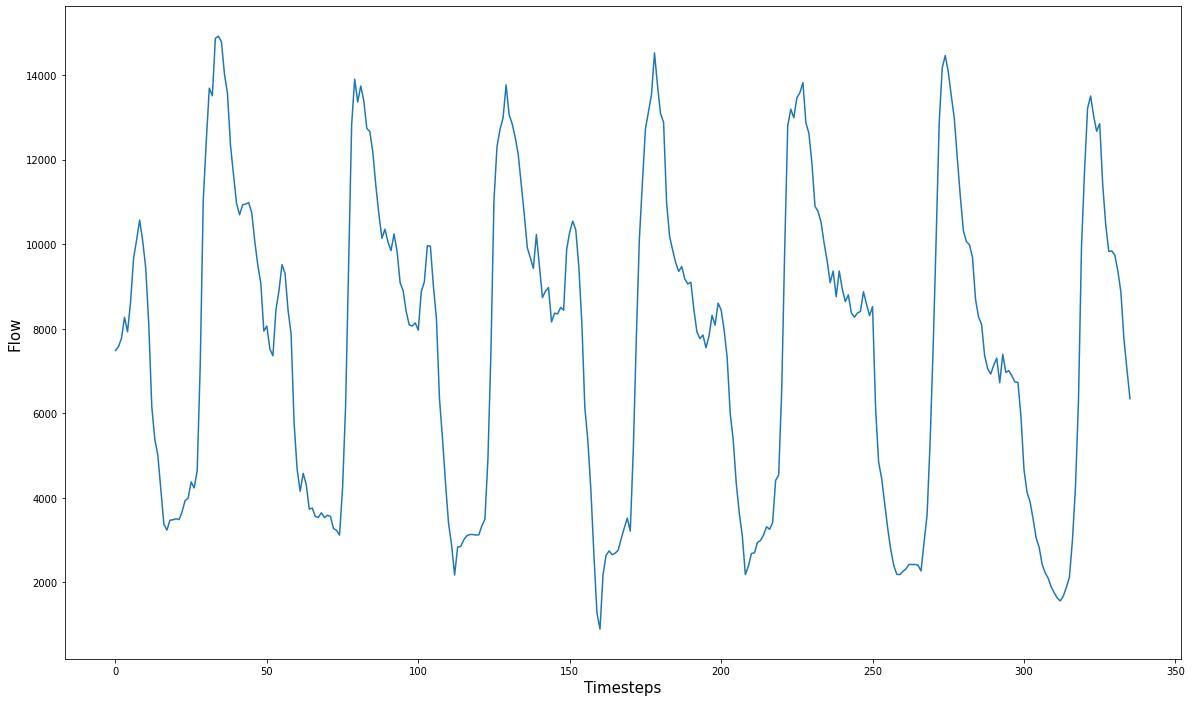

In [31]:
plt.plot(inverse_scaler(predicted_demand, minX, maxX))
plt.xlabel('Timesteps', fontsize = 15)
plt.ylabel('Flow', fontsize = 15)
plt.savefig('prediction.jpg')